whole people
system(int state, beta, gamma)
timefreame for schedule
run simulation (sys, sch)
    create results
    for t to t end
        get new beta
        update
        add to results
    return results

In [1]:
%matplotlib inline

from modsim import *
from pandas import read_excel

In [3]:
filename = "data/project2.xlsx"
table = read_excel(filename, header = 0, index_col = 0, sheetname = 'Sheet2')
#filename2 = "data/project2survey.xlsx"
#tableSurvey = read_excel(filename2, header = 0, index_col = 0)
#The first file is our chosen values, the second file is the survey data

In [4]:
table.columns = ['beta']
#tableSurvey.columns = ['beta']
#Dunno how the survey data is actually going to be formatted, so this is subject to change

In [7]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=349, I=1, R=0) #Upperclassmen arrived in the same week as freshmen this year, 
    init /= sum(init)             #so we can't really model it due to our time steps

    t0 = 1 #The chosen table starts at 1
    t_end = 38 #And ends at 39, but t + 1

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [8]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

pop = make_system(beta, gamma)
popFixedBeta = make_system(beta, gamma)

In [9]:
def updateVaryBeta(state, system, t, table):
    """Update the SIR model with varying beta.
    
    state: State with variables S, I, R
    system: System with beta and gamma
    t: Int representing current week
    table: DataTable of beta values
    
    returns: State object
    """
    s, i, r = state
    
    system.beta = update_beta(t, table) #Moved the varying of beta to the update function

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [15]:
def update(state, system, t, table):
    """Update the SIR model without varying beta.
    
    state: State with variables S, I, R
    system: System with beta and gamma
    t: Int representing current week
    table: DataTable of beta values
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [16]:
def update_beta(n, schedule):
    """Generates a new beta for the current week
    n: Integer, representing week number
    schedule: DataTable of beta values
    """
    beta = schedule.beta[n] + 0.08 #Added because the winter break is long enough that all diseases die out, which screws with the model
    return beta

In [17]:
def run_simulation(system, update_func, table):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    table: A DataTable of time and data
    """
    frame = DataFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], system, t, table)
    
    system.results = frame

In [18]:
def plot_results(system):
    """Plots the results of the system.
    
    system: System object
    """
    newfig()
    plot(system.results.S, "b-", label = "Susceptible")
    plot(system.results.I, "r-", label = "Infected")
    plot(system.results.R, "g", label = "Recovered")
    decorate(xlabel = "Time (Weeks)",
            ylabel = "Fraction of Population")

In [23]:
def plotDifference(series1, series2):
    """Plots the difference between series1 and series2
    
    series1: A TimeSeries of data
    series2: A TimeSeries of data
    """
    newfig()
    result = TimeSeries()
    for t in series1.index:
        result[t] = series1[t] - series2[t] #Creates a TimeSeries where the elements are the differences in the two series
    plot(result)
    decorate(xlabel = "Time (Weeks)",
            ylabel = "Error")

In [24]:
def getAverageDifference(series1, series2):
    """Takes the average difference of the elements in series1 and series2
    
    series1: A TimeSeries of data
    series2: A TimeSeries of data
    """
    result = 0
    for t in series1.index: 
        result += series1[t] - series2[t] #Takes the difference in each of the elements of the series and sums them
    result = result / series1.index.size #Apparently, this is how you get the number of elements in an index?
    return result

In [25]:
run_simulation(pop, updateVaryBeta, table)
run_simulation(popFixedBeta, update, table)

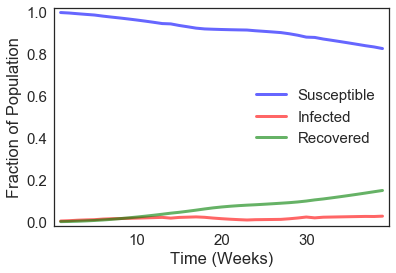

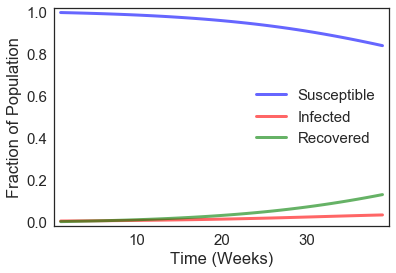

In [27]:
plot_results(pop)
plot_results(popFixedBeta)

1